# Test SO-101 lerobot libaries

## Calibration

Using notebook for calibraion is a pain so you should use cli commands.

### Leader Arm

```
sudo chmod 666 /dev/ttyACM0
```

```
lerobot-calibrate \
    --teleop.type=so101_leader \
    --teleop.port=/dev/ttyACM0 \
    --teleop.id=annarborace01_leader_arm
```

### Follower Arm
```
sudo chmod 666 /dev/ttyACM1
```

```
lerobot-calibrate \
    --robot.type=so101_follower \
    --robot.port=/dev/ttyACM1 \
    --robot.id=annarborace01_follower_arm 
```

## Arm Control

### Control Motor Joint With Keyboard

#### Initialize a follower

In [3]:
robot_id = "annarborace01_follower_arm"
robot_port = "/dev/ttyACM1"


from lerobot.robots.so101_follower import SO101Follower, SO101FollowerConfig

config = SO101FollowerConfig(
    port=robot_port,
    id=robot_id,
)
follower = SO101Follower(config)

for motor, motor_id in follower.bus.motors.items():
    print(motor, motor_id)

follower.connect()

shoulder_pan Motor(id=1, model='sts3215', norm_mode=<MotorNormMode.RANGE_M100_100: 'range_m100_100'>)
shoulder_lift Motor(id=2, model='sts3215', norm_mode=<MotorNormMode.RANGE_M100_100: 'range_m100_100'>)
elbow_flex Motor(id=3, model='sts3215', norm_mode=<MotorNormMode.RANGE_M100_100: 'range_m100_100'>)
wrist_flex Motor(id=4, model='sts3215', norm_mode=<MotorNormMode.RANGE_M100_100: 'range_m100_100'>)
wrist_roll Motor(id=5, model='sts3215', norm_mode=<MotorNormMode.RANGE_M100_100: 'range_m100_100'>)
gripper Motor(id=6, model='sts3215', norm_mode=<MotorNormMode.RANGE_0_100: 'range_0_100'>)


#### Usage Options

**NOTE**: 
- !!!! Once exist, it will disable torque. So make sure the arm joints are in good torque free positions !!!!
- !!!! If you interupt the cell instead of ESC existing, you should run the last cell to disable torque !!!!

**Available Motors:**
1. shoulder_pan (ID: 1)
2. shoulder_lift (ID: 2)
3. elbow_flex (ID: 3)
4. wrist_flex (ID: 4)
5. wrist_roll (ID: 5)
6. gripper (ID: 6)

**Controls:**
- LEFT/RIGHT arrows: ±5.0
- SPACE: Show current position
- ESC: Exit control mode


In [4]:
from pynput import keyboard

class KeyboardJointController:
    def __init__(self, follower, motor_name: str):
        self.follower = follower
        self.motor_name = motor_name
        self.current_position = 0.0
        self.running = True
        
        # Step sizes
        self.small_step = 1.0  # up/down arrows
        self.large_step = 5.0  # left/right arrows
        
        self.motor_info = follower.bus.motors[motor_name]
        print(f"\nControlling: {motor_name} (ID: {self.motor_info.id})")
        
    def read_position(self):
        positions = self.follower.bus.sync_read("Present_Position")
        return positions.get(self.motor_name, 0.0)
    
    def send_position(self, position: float):
        action = {f"{self.motor_name}.pos": position}
        self.follower.send_action(action)
    
    def update_position(self, delta: float):
        current = self.read_position()
        new_position = current + delta
        
        # Clamp based on normalization mode
        if self.motor_info.norm_mode.value == "range_0_100":
            new_position = max(0.0, min(100.0, new_position))
        else:  # range_m100_100
            new_position = max(-100.0, min(100.0, new_position))
        
        self.send_position(new_position)
    
    def on_press(self, key):
        try:
            if key == keyboard.Key.right:
                self.update_position(self.large_step)
            elif key == keyboard.Key.left:
                self.update_position(-self.large_step)
            elif key == keyboard.Key.space:
                pos = self.read_position()
                print(f"Current position: {pos:.2f}")
            elif key == keyboard.Key.esc:
                print("\nStopping...")
                self.running = False
                self.follower.bus.disable_torque()
                return False
        except AttributeError:
            pass
    
    def run(self):
        print("="*50)
        print("KEYBOARD CONTROL")
        print("="*50)
        print("UP/DOWN: ±1.0 | LEFT/RIGHT: ±5.0")
        print("SPACE: Show position | ESC: Exit")
        print("="*50)
        
        initial = self.read_position()
        print(f"Initial position: {initial:.2f}\n")
        
        with keyboard.Listener(on_press=self.on_press) as listener:
            listener.join()

def select_motor_interactive(follower):
    """Display motor menu and get user selection."""
    print("\n" + "="*70)
    print("AVAILABLE MOTORS")
    print("="*70)
    
    motor_list = list(follower.bus.motors.items())
    
    for idx, (name, motor) in enumerate(motor_list, 1):
        print(f"{idx}. {name:15} Motor(id={motor.id}, model='{motor.model}', norm_mode={motor.norm_mode.value})")
    
    print("="*70)
    
    while True:
        try:
            choice = input("\nSelect motor (1-6): ").strip()
            choice_num = int(choice)
            
            if 1 <= choice_num <= len(motor_list):
                selected_motor = motor_list[choice_num - 1][0]
                print(f"\nSelected: {selected_motor}")
                return selected_motor
            else:
                print(f"Please enter a number between 1 and {len(motor_list)}")
        except ValueError:
            print("Invalid input. Please enter a number between 1-6")
        except KeyboardInterrupt:
            print("\n\nCancelled")
            return None


In [5]:
# Usage with interactive selection:
motor_name = select_motor_interactive(follower)
if motor_name:
    controller = KeyboardJointController(follower, motor_name)
    controller.run()


AVAILABLE MOTORS
1. shoulder_pan    Motor(id=1, model='sts3215', norm_mode=range_m100_100)
2. shoulder_lift   Motor(id=2, model='sts3215', norm_mode=range_m100_100)
3. elbow_flex      Motor(id=3, model='sts3215', norm_mode=range_m100_100)
4. wrist_flex      Motor(id=4, model='sts3215', norm_mode=range_m100_100)
5. wrist_roll      Motor(id=5, model='sts3215', norm_mode=range_m100_100)
6. gripper         Motor(id=6, model='sts3215', norm_mode=range_0_100)

Selected: shoulder_pan

Controlling: shoulder_pan (ID: 1)
KEYBOARD CONTROL
UP/DOWN: ±1.0 | LEFT/RIGHT: ±5.0
SPACE: Show position | ESC: Exit
Initial position: -7.47


Stopping...


In [6]:
controller.follower.bus.disable_torque()

## Cameras

`v4l2-ctl --list-devices` to check the path of you camera

Async frame 0 shape: (480, 640, 3)


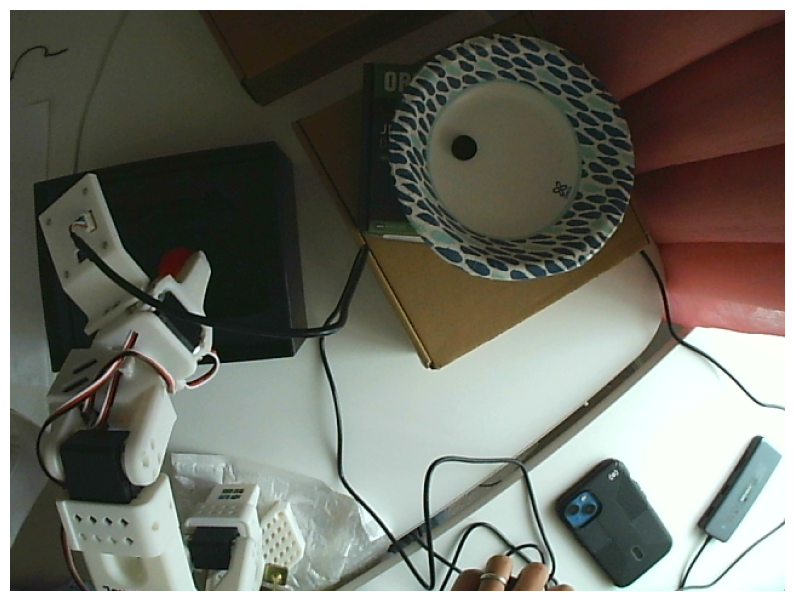

In [10]:
from lerobot.cameras.opencv.configuration_opencv import OpenCVCameraConfig
from lerobot.cameras.opencv.camera_opencv import OpenCVCamera
from lerobot.cameras.configs import ColorMode, Cv2Rotation

import matplotlib.pyplot as plt

device_path = '/dev/video51'

# Construct an `OpenCVCameraConfig` with your desired FPS, resolution, color mode, and rotation.
config = OpenCVCameraConfig(
    index_or_path=device_path,
    fps=25,
    width=640,
    height=480,
    #width=800,
    #height=600,
    color_mode=ColorMode.RGB,
    rotation=Cv2Rotation.NO_ROTATION
)

# Instantiate and connect an `OpenCVCamera`, performing a warm-up read (default).
camera = OpenCVCamera(config)
camera.connect()

# Read frames asynchronously in a loop via `async_read(timeout_ms)`
try:
    for i in range(1):
        frame = camera.async_read(timeout_ms=200)
        print(f"Async frame {i} shape:", frame.shape)
        
        # Display the image
        plt.figure(figsize=(10, 8))
        plt.imshow(frame)
        plt.axis('off')
        plt.show()
finally:
    camera.disconnect()